In [1]:
from cpymad.madx import Madx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import stats
from scipy.optimize import least_squares as ls
from scipy.optimize import minimize as som

from scipy.optimize import fmin_cobyla


from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# standard configurations
get_ipython().magic('matplotlib inline')
%config InlineBackend.figure_format = 'retina' # retina display

# in order to have fancy plots with lattice
def plotLatticeSeries(ax, series, height=1., v_offset=0., color='r',alpha=0.5,lw=1):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;

# Home-made truncated gaussian distribution
def trun_norm(cut):
    x = np.random.normal()
    return x+cut if np.abs(x)<cut else trun_norm(cut)

/home/dmitrii/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
myString='''
! *********************************************************************
! Definition of parameters
! *********************************************************************

l_cell=110;
quadrupoleLenght=5;
f=30;
kf:=1/f/quadrupoleLenght;// m^-2
kd:=-1/f/quadrupoleLenght - kf/100;// m^-2

k_corr_1 := 0;
k_corr_2 := 0;

! *********************************************************************
! Definition of magnet
! ********************************************************************* 
QF: quadrupole, L=quadrupoleLenght, K1:=kf;
QD: quadrupole, L=quadrupoleLenght, K1:=kd;

CORR: HKICKER, L=1;
BPM: HMONITOR, L=1;

! *********************************************************************
! Definition of sequence
! *********************************************************************
myCell:sequence, refer=entry, L=L_CELL;
CORR1: CORR, hkick :=k_corr_1, at=0;
QF1: QF, at =10;
CORR2: CORR, hkick :=k_corr_2, at=50;
QD1: QD, at=60;
BPM1: BPM, at=75;
endsequence;

! *********************************************************************
! Definition of beam
! *********************************************************************
beam, particle=proton, energy=2;

! *********************************************************************
! Use of the sequence
! *********************************************************************
use, sequence=myCell;

! *********************************************************************
! TWISS
! *********************************************************************
twiss;
'''



In [3]:
madx = Madx(stdout=False)
#madx = Madx()

madx.input(myString)

dxdy = [trun_norm(2.5) for i in range(2*2)]

madx.input('''
addquaderr(dx_err,dy_err,quadname): macro = {
SELECT, FLAG=error, clear;
eoption, add=false;
SELECT, FLAG=error, PATTERN="quadname";

EALIGN, DX:=0.01*(dx_err-2.5), DY:=0.01*(dy_err-2.5); 
};''');

madx.input('''
exec, addquaderr({},{},QF1);
exec, addquaderr({},{},QD1);

SELECT, FLAG = ERROR, FULL;
ESAVE, FILE = err.txt;

select,flag=interpolate, class=drift, slice=20, range=#s/#e;
twiss;

'''.format(*dxdy))

DF0=madx.table.twiss.dframe()
bpmDF0 = DF0[DF0["keyword"]=="hmonitor"]
qsPos = DF0[DF0["keyword"]=="quadrupole"]

err =madx.table.efield.dframe()
qsERR = err[err["name"].str.contains("q")]

madx.input('''
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
twiss;''')

myTwiss=madx.table.twiss.dframe()


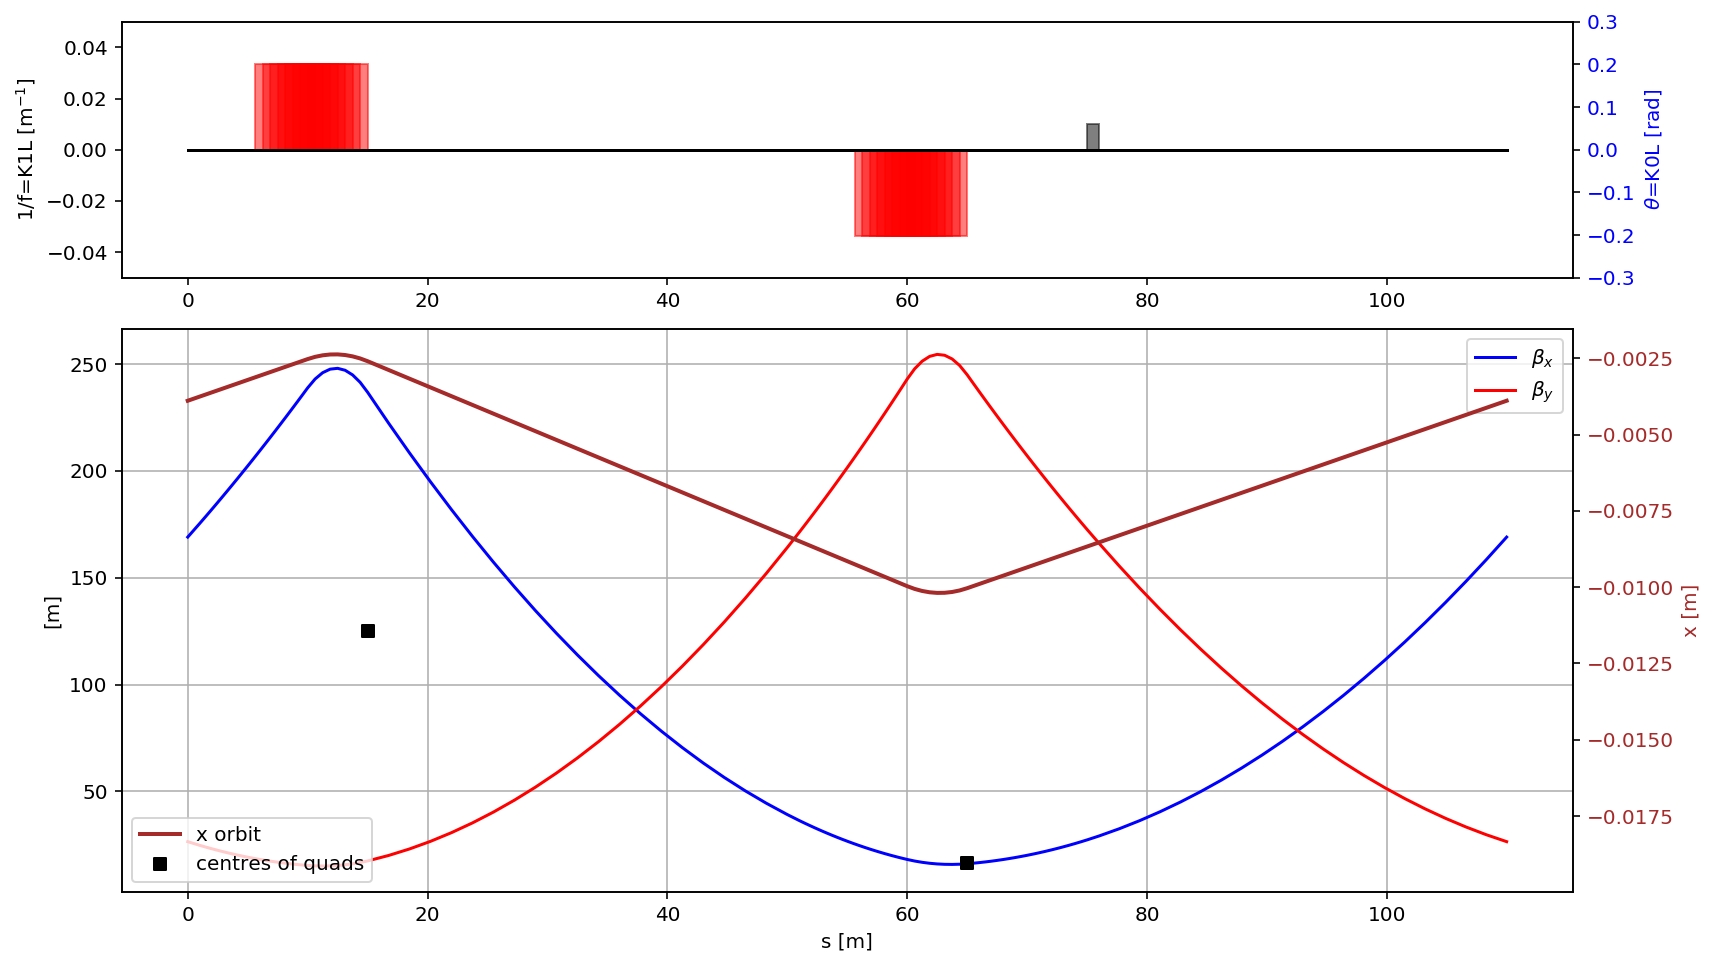

In [4]:
# just plotting
fig = plt.figure(figsize=(13,8))
ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')

DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='hkicker')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.hkick, v_offset=aux.hkick/2, color='blue')
    color = 'red'

DF=myTwiss[(myTwiss['keyword']=='hmonitor')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=0.01, v_offset=0.005, color='black')
    color = 'black'

    
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.05,.05)
#plt.title(f'CAS-19, $\\mu_x$ of the cell={madx.table.summ.Q1[0]/ncell: 2.3f},\
#$\\mu_y$ of the cell={madx.table.summ.Q1[0]/ncell: 2.3f}')
ax2 = ax1.twinx()

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)
ax2.tick_params(axis='y', labelcolor=color)

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k2l, v_offset=aux.k2l/2, color='y')

DF=myTwiss[(myTwiss['keyword']=='sbend')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='b')

    
plt.ylim(-.3,.3)

axbeta=plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.legend(loc='best')

plt.grid()

ax3 = plt.gca().twinx() 
plt.plot(myTwiss['s'],myTwiss['x'],'brown', label='x orbit', lw=2)
plt.scatter(qsPos.s,qsERR.dx, label="centres of quads", marker = "s", color = "black")

ax3.set_ylabel('x [m]', color='brown')
ax3.tick_params(axis='y', labelcolor='brown')
plt.legend(loc='best')
#plt.ylim(0, 10);

In [5]:
# constraint for cobyla here
def con1(x):
    return 0.05*np.sqrt(2)-np.sum(x**2)
    

#=========================================================================================

# scalar function, it is the characterization of full X-orbit
# The argument is numpy array (list of kickers), len = 8
# returns dx/dk
def find_gradient_x(theta):

    
    kf0 =1/30/5
    kd0 =-1/30/5-1/30/5/100
    delta = kf0/10

    madx.input('''kf ={}; kd ={};k_corr_1 = {};k_corr_2 ={};twiss;'''.format(kf0,kd0,*theta));

    aux=madx.table.twiss.dframe()
    xbpm0 =aux[aux["keyword"]=="hmonitor"]["x"]

    madx.input('''kf ={}; kd ={};twiss;'''.format(kf0+delta,kd0+delta));

    aux=madx.table.twiss.dframe()
    xbpm = aux[aux["keyword"]=="hmonitor"]["x"]

    vecf = np.array(xbpm-xbpm0)/delta

    return np.linalg.norm(vecf)


#=========================================================================================



def find_orb_x(theta):
      
    madx.input('''k_corr_1 = {};k_corr_2 ={};
    select,flag=interpolate, class=drift, slice=20, range=#s/#e;
    select,flag=interpolate, class=quadrupole, slice=1, range=#s/#e;
    twiss;
    '''.format(*theta));
    
    aux=madx.table.twiss.dframe()
    xq =aux[aux["keyword"]=="quadrupole"]["x"]
    
    aux =madx.table.efield.dframe()
    Qerr = aux[aux["name"].str.contains("q")]
    
    vec = np.array(np.array(xq)-np.array(Qerr["dx"]))
#    print(vec)

    return np.linalg.norm(vec)




In [6]:
theta_x = np.random.normal(0,0.00001,2)
cons = [{"type": "ineq", "fun": con1}]

vec_xg = som(find_gradient_x, theta_x, method="COBYLA", constraints=cons, options={'rhobeg': .00001, 'disp': True})
vec_xo = som(find_orb_x, theta_x, method="COBYLA", constraints=cons, options={'rhobeg': .00001, 'disp': True})
print(vec_xg)
print(vec_xo)

     fun: 0.15352748419032117
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 18
  status: 1
 success: True
       x: array([-1.21558588e-04, -8.51117025e-05])
     fun: 0.004830332534376436
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 19
  status: 1
 success: True
       x: array([-1.38168078e-04, -7.53491426e-05])


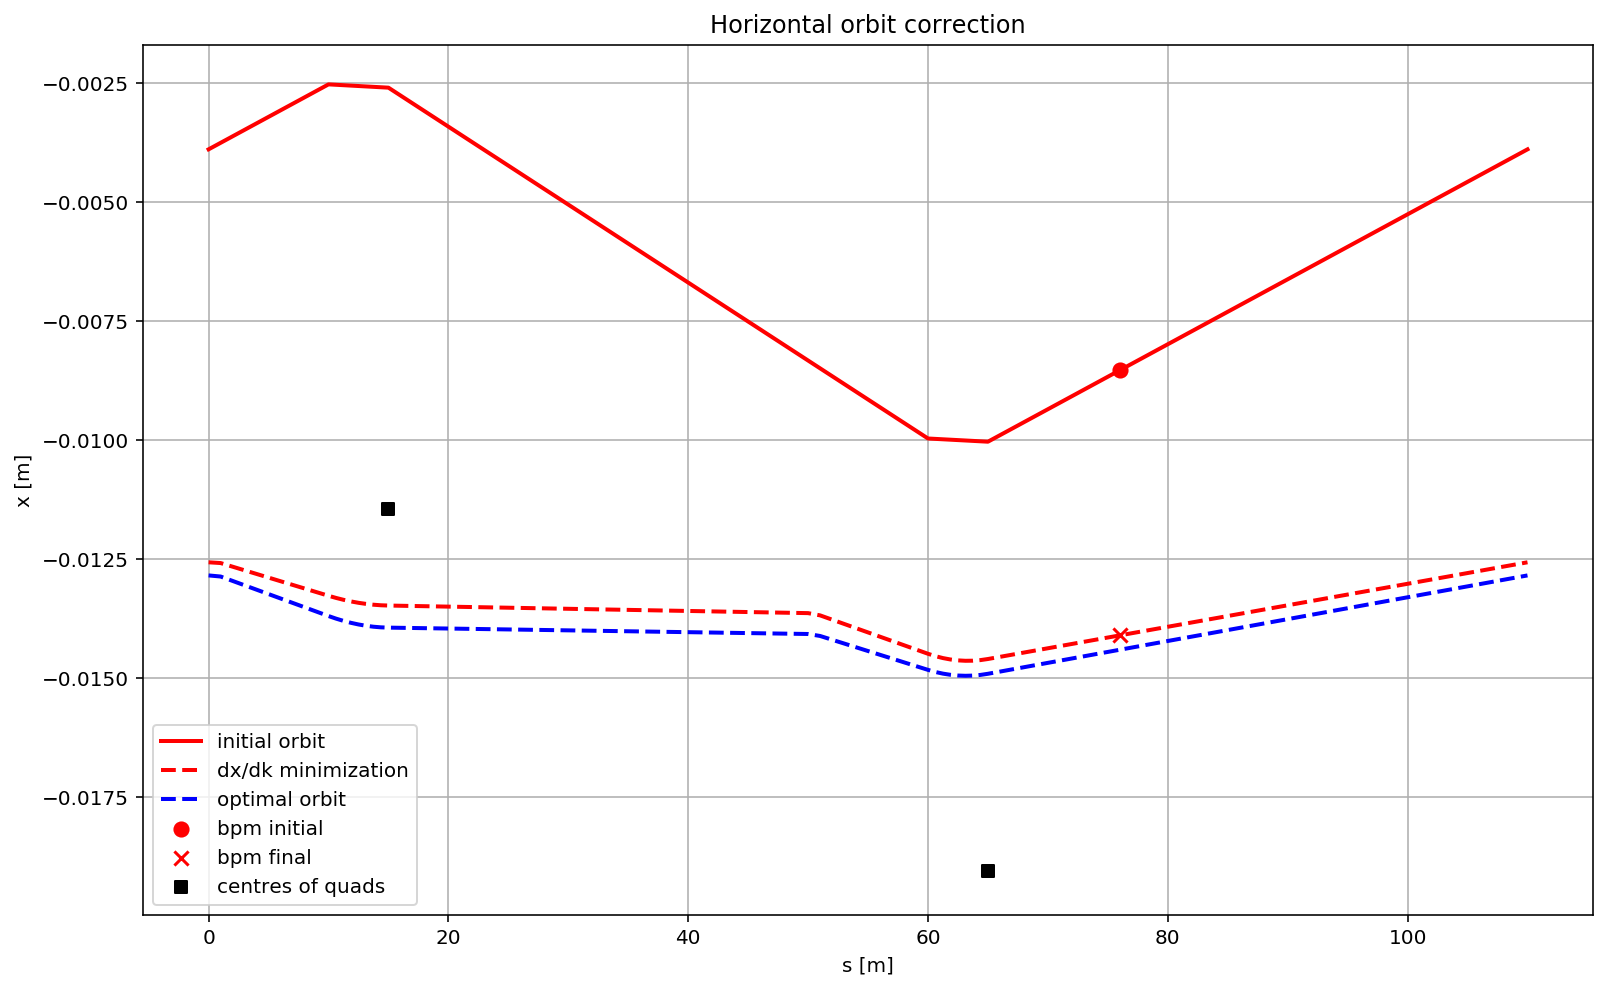

In [7]:
madx.input('''k_corr_1 = {};k_corr_2 ={};
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
twiss;'''.format(*vec_xg.x));

DF=madx.table.twiss.dframe()
bpmDF = DF[DF["keyword"]=="hmonitor"]

madx.input('''k_corr_1 = {};k_corr_2 ={};
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
twiss;'''.format(*vec_xo.x));

DF1=madx.table.twiss.dframe()
bpmDF1 = DF1[DF1["keyword"]=="hmonitor"]

# plotting
# red dashed line stands for find_grad, blue dashed for find_orb

fig = plt.figure(figsize=(13,8))
plt.plot(DF0['s'],DF0['x'],'r', label='initial orbit', lw=2)
plt.scatter(bpmDF0.s,bpmDF0.x, color = "red", s = 50, label="bpm initial")

plt.plot(DF['s'],DF['x'],'r',ls="--", label='dx/dk minimization', lw=2)
plt.scatter(bpmDF.s,bpmDF.x, color = "red", s = 50, marker="x", label="bpm final")

plt.plot(DF1['s'],DF1['x'],'blue',ls="--", label='optimal orbit', lw=2)

plt.scatter(qsPos.s,qsERR.dx, label="centres of quads", marker = "s", color = "black")

plt.legend(loc='best')
plt.title("Horizontal orbit correction")
plt.ylabel('x [m]')
plt.xlabel('s [m]')
plt.grid()


In [8]:
# this method applies errors to the lattice
# note, that all correctors are set to zero here
def add_err():

    dxdy = [trun_norm(2.5) for i in range(2*2)]

    out =madx.input('''
    
    k_corr_1 = 0.0;k_corr_2 = 0.0;
    
    exec, addquaderr({},{},QF1);
    exec, addquaderr({},{},QD1);

    SELECT, FLAG = ERROR, FULL;
    ESAVE, FILE = err.txt;

    twiss;

    '''.format(*dxdy))
    return out




In [9]:

df = pd.DataFrame(columns=["x(0)","dx/dk(0)","n", "theta_1", "theta_2"])
#df = pd.DataFrame(columns=["x(0)","dx/dk(0)"])

for i in range(50):
    a = add_err()
    if a:
        aux=madx.table.twiss.dframe()
        x0 = np.array(aux[aux["keyword"]=="hmonitor"]["x"])[0]
        dxdk0 =find_gradient_x(np.zeros(2))
        
        theta_x = np.random.normal(0,0.00001,2) # random conditions for all /// try from theta = 0
        vec = som(find_orb_x, theta_x, method="COBYLA", constraints=cons, options={'rhobeg': .00001, 'disp': True})
        
        if dxdk0 > find_gradient_x(vec.x):
            df =df.append({"x(0)":x0,"dx/dk(0)":dxdk0, "n":vec.nfev,"dx":vec.fun, "theta_1":vec.x[0], "theta_2":vec.x[1]},ignore_index=True)

    


In [10]:
max_depth = 20
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=20,max_depth=max_depth, random_state=0))

feature_cols = ["x(0)","dx/dk(0)"]
target_cols = ["theta_1","theta_2"]
X = df[feature_cols]
Y = df[target_cols]
n = len(df)
print(n)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=int(8*n/10), test_size=n-int(8*n/10), random_state=2)

regr_multirf.fit(X_train, Y_train)
y_multirf = regr_multirf.predict(X_test)

47


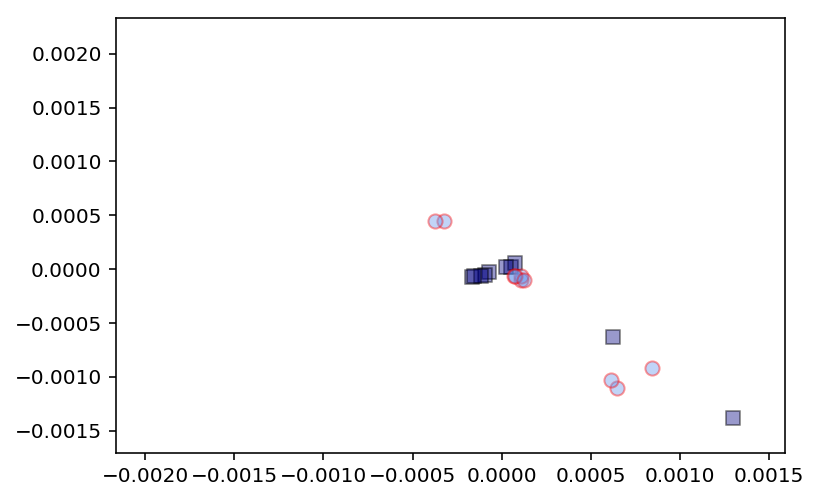

In [11]:
plt.figure()
s = 50
a = 0.4
plt.scatter(Y_test["theta_1"], Y_test["theta_2"], edgecolor='k', c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='r',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(X_test, Y_test))

plt.xlim([df["theta_1"].min(), df["theta_1"].max()])
plt.ylim([df["theta_2"].min(), df["theta_2"].max()])
plt.show()

In [12]:
add_err()
DF0=madx.table.twiss.dframe()
x0 = np.array(DF0[DF0["keyword"]=="hmonitor"]["x"])[0]
dxdk0 =find_gradient_x(np.zeros(2))

vec_predict = regr_multirf.predict([[x0,dxdk0]])

err1 =madx.table.efield.dframe()
qsERR1 = err1[err1["name"].str.contains("q")]
qsPos1 = DF0[DF0["keyword"]=="quadrupole"]


In [13]:
vec_xg = som(find_gradient_x, vec_predict[0], method="COBYLA", constraints=cons, options={'rhobeg': .00001, 'disp': True})
vec_xo = som(find_orb_x, np.random.normal(0,0.00001,2), method="COBYLA", constraints=cons, options={'rhobeg': .00001, 'disp': True})

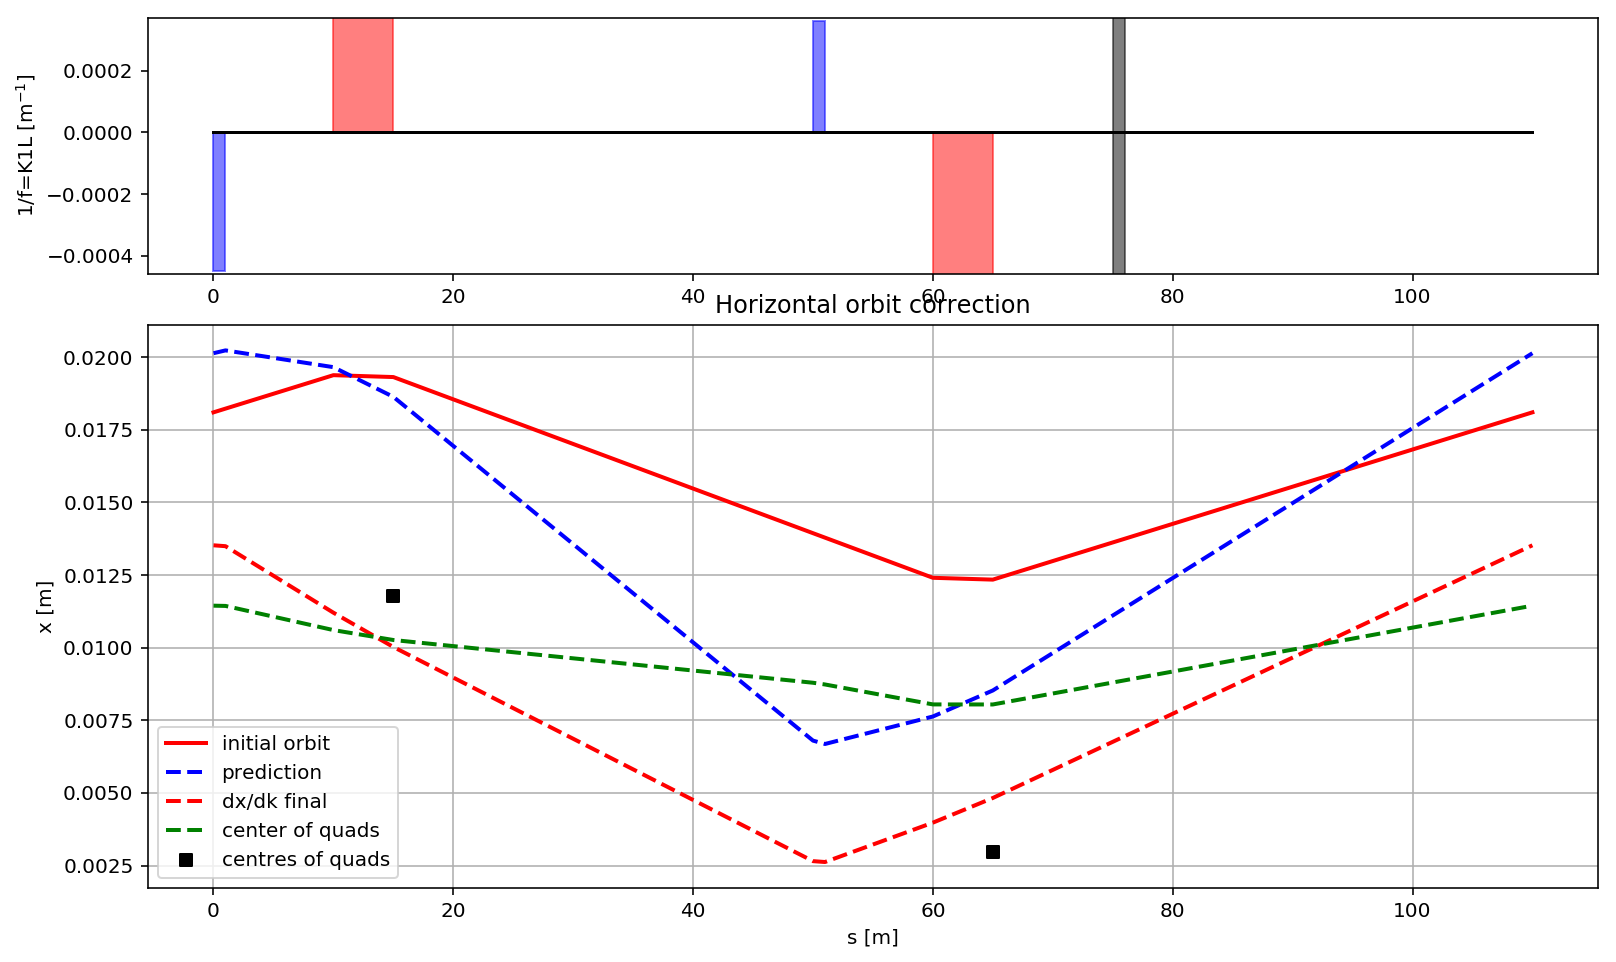

In [14]:
madx.input('''k_corr_1 = {};k_corr_2 ={};
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
!select,flag=interpolate, class=quadrupole, slice=1, range=#s/#e;
twiss;'''.format(*vec_predict[0]));

DF=madx.table.twiss.dframe()

madx.input('''k_corr_1 = {};k_corr_2 ={};twiss;'''.format(*vec_xg.x));

DF1=madx.table.twiss.dframe()
bpmDF1 = DF1[DF1["keyword"]=="hmonitor"]


madx.input('''k_corr_1 = {};k_corr_2 ={};twiss;'''.format(*vec_xo.x));

DF2=madx.table.twiss.dframe()

# plotting
fig = plt.figure(figsize=(13,8))
ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')

tmp=DF1[DF1['keyword']=='quadrupole']
for i in range(len(tmp)):
    aux=tmp.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

hk = []
tmp=DF1[(DF1['keyword']=='hkicker')]
for i in range(len(tmp)):
    aux=tmp.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.hkick, v_offset=aux.hkick/2, color='blue')
    hk.append(aux.hkick)
    color = 'red'

tmp=DF1[(DF1['keyword']=='hmonitor')]
for i in range(len(tmp)):
    aux=tmp.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=0.01, v_offset=0.005, color='black')
    plotLatticeSeries(plt.gca(),aux, height=0.01, v_offset=-0.005, color='black')
    color = 'black'

    
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(min(hk)-10**(-5),max(hk)+10**(-5))

axbeta=plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)


plt.plot(DF0['s'],DF0['x'],'r', label='initial orbit', lw=2)

plt.plot(DF['s'],DF['x'],'blue',ls="--", label='prediction', lw=2)
plt.plot(DF1['s'],DF1['x'],'red',ls="--", label='dx/dk final', lw=2)
plt.plot(DF2['s'],DF2['x'],'green',ls="--", label='center of quads', lw=2)

plt.scatter(qsPos1.s,qsERR1.dx, label="centres of quads", marker = "s", color = "black")

plt.legend(loc='best')
plt.title("Horizontal orbit correction")
plt.ylabel('x [m]')
plt.xlabel('s [m]')
plt.grid()


In [15]:
df.to_csv("inverse_regression.csv")